## Permutation Tests
### Exact Tests
Consider the following experiment from [An Introduction to the Bootstrap](https://books.google.com/books?id=MWC1DwAAQBAJ&printsec=frontcoverhttps://books.google.com/books?id=MWC1DwAAQBAJ&printsec=frontcover). A new medical treatment is intended to prolong life after a form of surgery. Sixteen mice are randomly assigned to either a treatment group or control group under the constraint that only seven treatments are available. All mice receive the surgery, but only the treatment group will receive the treatment being studied. The survival time of each mouse after surgery is recorded below.

In [1]:
# survival times measured in days
import numpy as np
x = np.array([94, 197, 16, 38, 99, 141, 23])  # treatment group
y = np.array([52, 104, 146, 10, 51, 30, 40, 27, 46])  # control group

The difference in the mean life after treatment between the two groups suggests that the treatment has a prolonging effect, as hypothesized.

In [2]:
def statistic(x, y):
    return np.mean(x) - np.mean(y)
print(statistic(x, y))

30.63492063492064


It is possible that the treatment has no effect in reality; perhaps the apparent prolonging effect of the treatment is due to the inherent variability in survival times and chance alone. This possibility is typically assessed using Student's t-test. A common formulation of the test begins with the null hypothesis that the survival times `x` and `y` are sampled at random from normal distributions $X$ and $Y$ with means $\mu_x$ and $\mu_y$ and a common standard deviation, $\sigma$. To test the null hypothesis that $\mu_x = \mu_y$ against the alternative that $\mu_x > \mu_y$, we perform the independent sample t-test with `stats.ttest_ind`.

In [3]:
from scipy import stats
stats.ttest_ind(x, y, equal_var=True, alternative='greater')

Ttest_indResult(statistic=1.1208453991208167, pvalue=0.14060629239765005)

The probability of observing such an extreme test statistic under the null hypothesis (due to chance alone) is greater than 14%, so these data do not seem inconsistent with the null hypothesis. The *point estimate* of the statistic (~30 days) suggested a life-prolonging effect, but such a value of the statistic could quite easily have been observed due to chance alone.

Although the t-test tends to be rather robust to violations of its underlying assumptions (e.g., $X$ and $Y$ do not need to be strictly normally distributed for the test to be reasonably accurate), it is possible to perform a hypothesis test which requires no such assumptions at all. 

Instead, let the null hypothesis be that the samples `x` and `y` are drawn a single distribution ($X = Y = Z$), and test this against the alternative that the two sample are drawn from distributions which would tend to produce greater values of `statistic`. 

The complete population of mice survival times in the study is really:

In [4]:
z = np.concatenate([x, y])
print(z)

[ 94 197  16  38  99 141  23  52 104 146  10  51  30  40  27  46]


Since the mice were randomly divided into the two groups under the constraint that there were only seven treatments available, any selection of seven mice from `z` to form the treatment group `x` was equally likely; the remaining mice would form the control group `y`. Furthermore, if the null hypothesis is true, the mice survival times would be *unaffected by the grouping*. Therefore, each value of the statistic obtained from the possible groupings is equaly likely.

We begin our hypothesis test by calculating the value of `statistic` for all possible *permutations*<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2) of mice into the the two groups, forming an exact null distribution.

<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2) Here and below, we will refer to the the ways of rearranging samples as "permutations" even when the word is not stricly appropriate in the technical sense. 

Text(0, 0.5, 'Observed Frequency')

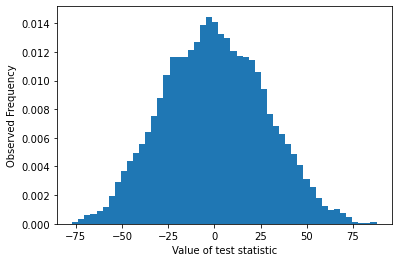

In [5]:
from itertools import combinations
import matplotlib.pyplot as plt

def null_distribution(z, nx):
    # z is the population of mice survival times in the study
    # nx is the number of mice in the treatment group
    z = set(z)
    null_distribution = []
    for x in combinations(z, nx):
        y = z - set(x)
        stat = statistic(list(x), list(y))
        null_distribution.append(stat)
    return null_distribution

null_dist = null_distribution(z, len(x))
plt.hist(null_dist, density=True, bins=50)
plt.xlabel("Value of test statistic")
plt.ylabel("Observed Frequency")

We complete the hypothesis test by comparing the observed value of the test statistic to the rest of the null distribution.

In [6]:
pvalue = np.sum(null_dist >= statistic(x, y) ) / len(null_dist)
print(pvalue)

0.1409965034965035


Approximately 14% of the values of the null distribution are greater than the observed value of the statistic, so there is a 14% probability of observing such an extreme value of the statistic even if the the treatment had no effect at all. 

Given data and a statistic function, `stats.permutation_test` performs the same test automatically.

In [7]:
# `alternative` is 'greater' because we are interested in the percentage of values in the
#  null distribution that are greater than the observed value of the test statistic.
# `n_resamples` is `np.inf` to ensure that all possible permutations are used
# Note that `(x, y)`, a tuple, is a single argument.
res = stats.permutation_test((x, y), statistic, alternative='greater', n_resamples = np.inf)
assert res.pvalue == pvalue
print(res)

PermutationTestResult(statistic=30.63492063492064, pvalue=0.1409965034965035, null_distribution=array([ 30.63492063,  38.        ,  51.20634921, ..., -11.01587302,
       -45.55555556, -34.88888889]))


It returns the observed value of the test statistic, the null distribution, and the $p$-value. They are related as above:

In [8]:
assert np.sum(res.null_distribution >= res.statistic ) / len(res.null_distribution) == res.pvalue

Note that the exact $p$-value from the permutation test matches the $p$-value from the t-test quite closely. (As we shall see, Ronald Fisher introduced permutation tests primarily to support the use of the t-test in applications where the underlying normality assumptions were not strictly true [[4](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2458144/https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2458144/)].)

### Randomized Tests
The number of possible permutations grows rather quickly as the number of observations increases. Specifically, if $n_x$ and $n_y$ are the number of observations in `x` and `y`, respectively, than the number of possible permutations is $\frac{(n_x + n_y)!}{n_x! n_y!}$. 

In [9]:
from math import factorial as f
n_x = len(x)
n_y = len(y)
assert len(res.null_distribution) == f(n_x + n_y) / (f(n_x) * f(n_y))
print(len(res.null_distribution))

11440


When the number of possible permutations is too large, it is common to use a randomly-sampled subset of the possible permutations instead. As with `monte_carlo_test` the maximum number of resamples used by `permutation_test` is controlled using the `n_resamples` parameter.

In [10]:
# use only 4999 randomly-sampled permutations
res = stats.permutation_test((x, y), statistic, alternative='greater', n_resamples = 4999)
res.pvalue

0.1494

If the number of distinct permutations of the data is less than or equal to `n_resamples`, `permutation_test` performs an exact test, computing the value of the test statistic for each distinct permutation exactly once. If the number of distinct permutations exceeds `n_resamples`, `permutation_test` computes the value of the statistic for `n_resamples` random permutations, and the $p$-value is computed as:

In [11]:
pvalue = (np.sum(res.null_distribution >= res.statistic ) + 1) / (len(res.null_distribution) + 1)
assert pvalue == res.pvalue

Note that `1` is added to both the numerator and denominator when performing the randomized test [[3]](https://www.degruyter.com/document/doi/10.2202/1544-6115.1585/html). This can be thought of as including the observed value of the test statistic in the null distribution, and it ensures that the $p$-value of a randomized test is never zero.

A wide variety of common hypothesis tests can be performed as permutation tests. We continue with several other examples to explore the flexibility of `permutation_test`, beginning with [Independent-Sample Tests](https://nbviewer.org/github/mdhaber/scipy/blob/resampling_tutorial/doc/source/tutorial/stats/notebooks/resampling_tutorial_2a.ipynb).